# Analysing Calgary Campinas Dataset

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
from pathlib import Path
from torchsummaryX import summary
from tqdm import tqdm
from apeer_ometiff_library import io
from uda import UNetConfig, UNet
from uda.calgary_campinas_dataset import CalgaryCampinasDataset

data_dir = Path("/home/iailab36/iser/uda-data")
output_dir = Path("/home/iailab36/iser/uda-data/output")
output_dir.mkdir(exist_ok=True, parents=True)

sns.set_theme(style='darkgrid')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

Using device: cuda:0


Load the Calgary Campinas dataset.

In [2]:
train_dataset = CalgaryCampinasDataset(data_dir, vendor="GE_3", fold=1, train=True, rotate=True, flatten=True)
test_dataset = CalgaryCampinasDataset(data_dir, vendor="GE_3", fold=1, train=False, rotate=True, flatten=True)

print(train_dataset.data.shape)
print(train_dataset.label.shape)
print(train_dataset.voxel_dim.shape)

Loading files: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


torch.Size([8000, 1, 256, 256])
torch.Size([8000, 1, 256, 256])
torch.Size([8000, 1, 3])


Visualize some of the CT images.

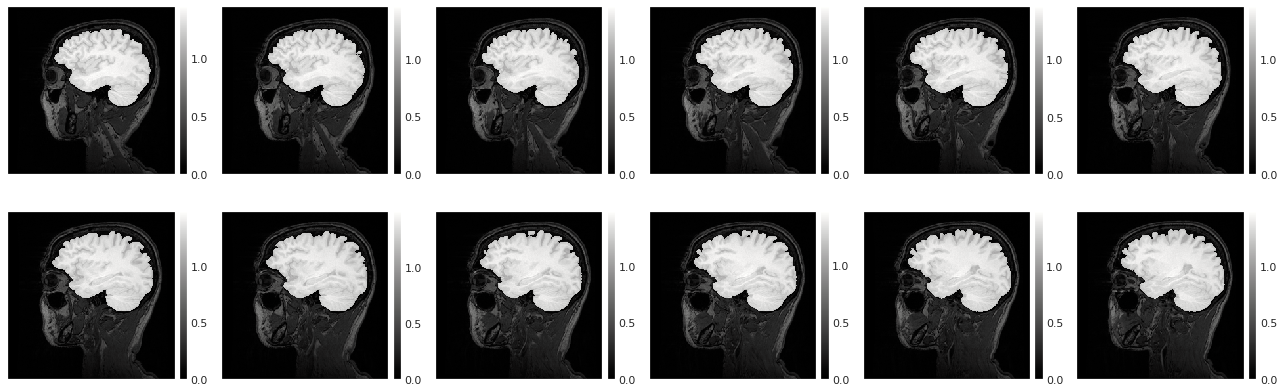

In [3]:
COLS = 6
N = 64
M = N + COLS*2

g = isns.ImageGrid(list((train_dataset.data + train_dataset.label)[N:M].squeeze()), col_wrap=COLS, cmap='gray')

## Training U-Net model

In [4]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# We use one encoder block less than the original U-Net, since our input is of shape (256, 256)
config = UNetConfig(
    n_classes=1,
    encoder_blocks=(
        (1, 32, 32),
        (32, 64, 64),
        (64, 128, 128),
        (128, 256, 256),
        (256, 512, 512),
    ),
    decoder_blocks=(
        (512, 256, 256),
        (256, 128, 128),
        (128, 64, 64),
        (64, 32, 32),
    ),
)

In [8]:
model = UNet(config)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"# parameters: {n_params:,}")

# architecture = summary(model, x=torch.randn(1, 1, 256, 256))

# parameters: 7,756,096


Dice score is a common measure of the quality of segmentation. It's defined as:
$$
DSC = 2 \cdot \frac{\vert Y_{\text{true}} \cap Y_{\text{pred}} \vert}{Y_{\vert\text{true}}\vert + \vert Y_{\text{pred}} \vert}
$$

In [9]:
def dice_score(pred: torch.Tensor, target: torch.Tensor) -> float:
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 2 * intersection / (pred.sum() + target.sum())

Train the model:

In [10]:
model = UNet(config).to(device)
optim = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

TEST_INTERVAL = 100
MAX_STEPS = 500

train_losses, test_losses = [], []
train_dscs, test_dscs = [], []

i = 0
dsc_test = 0
with tqdm(total=MAX_STEPS, desc="Training") as pbar:
    while i < MAX_STEPS:
        for x, y_true, _ in train_loader:
            i += 1
            if i > MAX_STEPS:
                break

            x = x.to(device)
            y_true = y_true.to(device)

            optim.zero_grad()
            y_pred = model(x)
            loss = F.binary_cross_entropy(y_pred, y_true)

            loss.backward()
            optim.step()

            train_losses.append(loss.item())
            train_dscs.append(dice_score(y_pred.detach(), y_true).item())

            if i % TEST_INTERVAL == 0:
                preds, targets = [], []
                with torch.no_grad():
                    preds, targets = [*zip(*[(model(x.to(device)).cpu(), y_true) for x, y_true, _ in test_loader])]
                    preds = torch.cat(preds)
                    targets = torch.cat(targets)
                    
                    test_losses.append(F.binary_cross_entropy(preds, targets).item())
                    test_dscs.append(dice_score(preds, targets).item())
                
            pbar.set_postfix({
                "loss": sum(train_losses[-5:]) / 5,
                "dsc_train": sum(train_dscs[-5:]) / 5,
                "dsc_test": test_dscs[-1] if test_dscs != [] else 0
            })
            pbar.update()

model.cpu();

Training: 100%|██████████| 500/500 [03:54<00:00,  2.13it/s, loss=0.065, dsc_train=0.81, dsc_test=0.813]  


Visualize losses and dice score:

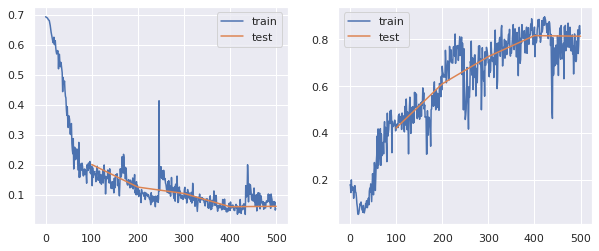

In [11]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(x=range(len(train_losses)), y=train_losses, label="train", ax=ax[0])
sns.lineplot(x=range(TEST_INTERVAL, len(train_losses)+1, TEST_INTERVAL), y=test_losses, label="test", ax=ax[0])

sns.lineplot(x=range(len(train_dscs)), y=train_dscs, label="train", ax=ax[1])
sns.lineplot(x=range(TEST_INTERVAL, len(train_dscs)+1, TEST_INTERVAL), y=test_dscs, label="test", ax=ax[1])

plt.legend()
plt.show()

Safe the model.

In [12]:
config.save(output_dir / "unet_config.json")
model.save(output_dir / "unet_model.pt")

## Analysing model outputs
! Restart notebook to free gpu memory

In [ ]:
# load pretrained model
config = UNetConfig.from_file(output_dir / "unet_config.json")
model = UNet.from_pretrained(output_dir / "unet_model.pt", config)

Gather model outputs:

In [13]:
model = model.to(device)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    data, label, pred = [*zip(*[(data, label, model(data.to(device)).cpu()) for data, label, _ in dataloader])]

data = torch.cat(data)
label = torch.cat(label)
pred = torch.cat(pred)

Predictions vs. ground truth:

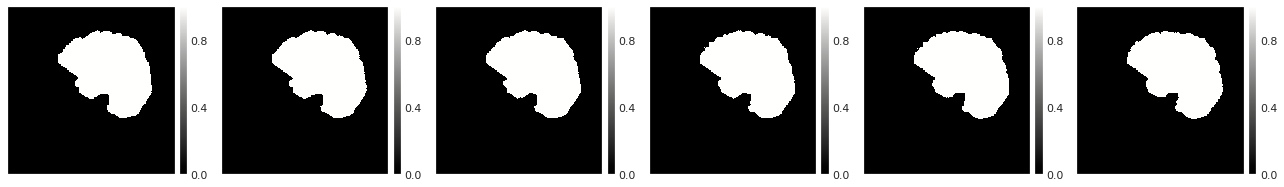

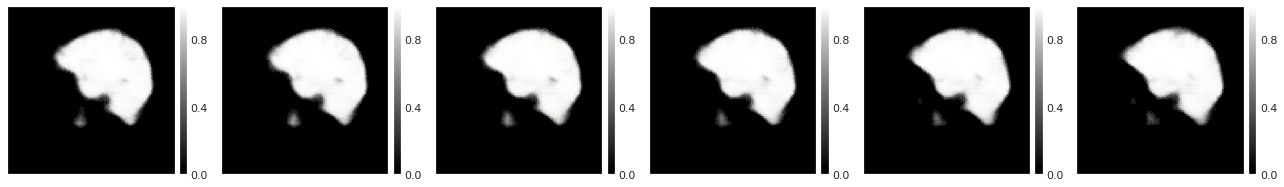

In [18]:
COLS = 6
N = 64
M = N + COLS

g = isns.ImageGrid(list((label)[N:M].squeeze()), col_wrap=COLS, cmap='gray')
g = isns.ImageGrid(list((pred)[N:M].squeeze()), col_wrap=COLS, cmap='gray')

### Safe predictions and ground truth as tif files

In [19]:
# avoid noise in mask
pred[pred < 0.1] = 0

# shape convention (T, Z, C, X, Y)
label = label[:200].unsqueeze(0).numpy().astype(np.uint8)
pred = pred[:200].unsqueeze(0).numpy().astype(np.uint8)

label.shape

(1, 200, 1, 256, 256)

In [20]:
io.write_ometiff(output_dir / "label.tif", label)
io.write_ometiff(output_dir / "pred.tif", pred)